In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

# Visualization
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import words, stopwords, wordnet
from nltk.tokenize import RegexpTokenizer

from collections import Counter

# Import regex and time
import re
import time

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from gensim.models import Phrases

import emoji

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

# Disable deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df = pd.read_csv("bad_reviews.csv")

In [3]:
df.head(5)

,stars,text
0,2,"We started with the artichoke dip, big mistake..."
1,1,"If I could give it a zero, I would. I order a ..."
2,1,Skip this train wreck if you are looking for d...
3,1,Service and management terrible... After messi...
4,1,Pretty slow service and the waitresses aren't ...


In [4]:
print(f"The dataframe is composed of {df.shape[0]} rows and {df.shape[1]} columns.")

The dataframe is composed of 185034 rows and 2 columns.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185034 entries, 0 to 185033
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   185034 non-null  int64 
 1   text    185034 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [6]:
df.isna().sum()

stars    0
text     0
dtype: int64

In [7]:
df.duplicated(subset=["text"]).sum()

314

In [73]:
df[df.duplicated(keep=False, subset=["text"])].sort_values(by="text")

,stars,text
8677,2,"""We ran out of bread"" they said, as we drove o..."
11204,2,"""We ran out of bread"" they said, as we drove o..."
66074,1,(0 stars if possible) I came here for the all ...
65631,1,(0 stars if possible) I came here for the all ...
97586,1,*Poor customer service \n*Your food may be giv...
...,...,...
97797,2,i'll start by saying my server was incredible....
152256,2,ordered a lot of food for a catered lunch. The...
152526,2,ordered a lot of food for a catered lunch. The...
165228,1,ordered an antipasto for two ($15) for takeout...


In [9]:
df.duplicated().sum()

297

In [69]:
df[df.duplicated()].sort_index()

,stars,text
2320,1,Certainly not worth the price. IMO food was no...
4214,2,"The service at Han Dynasty, Exton, was awful. ..."
4822,1,I was very unhappy with my last stay at Hard R...
6438,2,This coffee shop is NOT what Nashville is abou...
6441,2,This place has really gone downhill from what ...
...,...,...
182915,2,I once frequented this place for its outstandi...
183018,1,The food is ok but the service sucks they nee...
183241,1,DO NOT GO HERE!! This spot is the dirtiest res...
184185,2,"Not welcoming hosts, waitress did not comprehe..."


In [11]:
df.isna().mean().sort_values()

stars    0.0
text     0.0
dtype: float64

In [12]:
# Take sample of dataset

data = df.sample(n=5000, replace=False)

In [13]:
data.shape

(5000, 2)

In [14]:
data = data.reset_index().drop(columns=["index", "stars"])

In [15]:
data

,text
0,I waited a month before visiting Portillos to ...
1,I walked in and immediately noticed the very p...
2,"After paying over $600 a night for a room, you..."
3,"HORRIBLE SERVICE...too bad for me, the wings a..."
4,I'm not a local so I don't understand the mass...
...,...
4995,I saw reviews and was I interested in trying t...
4996,Food and service is horrible. Called to place ...
4997,"This is the worse restaurant in St. Charles, M..."
4998,We ordered takeout and spent $40 on dinner. It...


## Exploratory Data Analysis

In [16]:
data.text.head(20)

0     I waited a month before visiting Portillos to ...
1     I walked in and immediately noticed the very p...
2     After paying over $600 a night for a room, you...
3     HORRIBLE SERVICE...too bad for me, the wings a...
4     I'm not a local so I don't understand the mass...
5     Went tonight with a friend to try out the new ...
6     Rude,  cold fries, wrong drink, and mayo on my...
7     This store looks great but the person directin...
8     I wish I could give this restaurant a better r...
9     This was my third time eating at El Molinito o...
10    The drive through here is horrible! It never f...
11    Ridiculously high prices for low quality burge...
12    Ordered from tonight. Husband ordered a pepper...
13    Called to tell the restaurant we were going to...
14    As someone who has vacationed in Italy many ti...
15    Second visit during GeckoFest and was very dis...
16    Probably one of the worst experiences I have e...
17    Was really excited to try this place after

<AxesSubplot:>

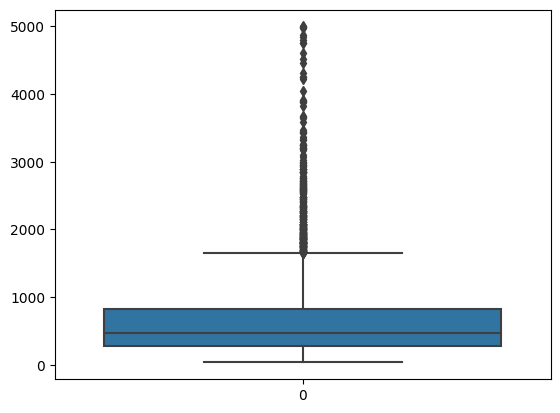

In [17]:
# String length

string_length = data.text.str.len()
sns.boxplot(string_length)

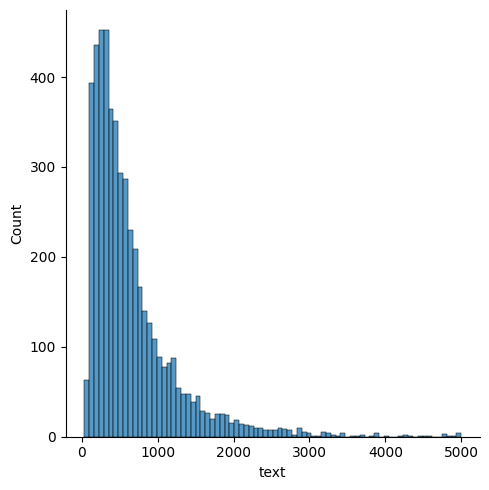

In [18]:
sns.displot(string_length)

## Document clean-up

In [19]:
def display_tokens_info(tokens):
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a stemmer in this case because it produces more readable words. Output that is easy to read is very desirable in topic modelling.

In [20]:
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')

def text_cleaner(text):

    text = emoji.demojize(text, delimiters=("", "")) # demojize the emojis in the docs

    text = text.lower() # to lowercase
    
    text = tokenizer.tokenize(text) # tokenize with regular expressions

    text = [w for w in text if w not in stop_words] # remove stopwords

    text = [lem.lemmatize(w) for w in text] # lemmatize with WordNetLemmatizer

    text = [w for w in text if len(w) > 3] # keep only words longer than 3 characters

    ### keep only nouns

    pos_tag = nltk.pos_tag(text)
    noun_text = []

    for i in range (0, (len(text)-1)):

        if (pos_tag[i][1] == 'NN'):
            noun_text.append(pos_tag[i][0])

    text = noun_text

    ###

    return text

In [21]:
data["clean_text"] = data["text"].apply(lambda row : text_cleaner(row))

In [22]:
data

,text,clean_text
0,I waited a month before visiting Portillos to ...,"[month, movie, burger, burger, area, chocolate..."
1,I walked in and immediately noticed the very p...,"[decor, service, food, waiter, time, visit, se..."
2,"After paying over $600 a night for a room, you...","[night, room, wait, line, paper, coffee, waste..."
3,"HORRIBLE SERVICE...too bad for me, the wings a...","[service, restaurant, industry, year, rush, pl..."
4,I'm not a local so I don't understand the mass...,"[understand, mass, appeal, place, food, bland,..."
...,...,...
4995,I saw reviews and was I interested in trying t...,"[review, sandwich, order, order, boyfriend, sa..."
4996,Food and service is horrible. Called to place ...,"[food, service, horrible, place, order, pick, ..."
4997,"This is the worse restaurant in St. Charles, M...","[restaurant, wife, pork, steak, brother, pork,..."
4998,We ordered takeout and spent $40 on dinner. It...,"[spent, dinner, bread, roach, point]"


## Check our progress

In [23]:
corpus_original = wordpunct_tokenize(" ".join(data.text.values))
corpus_clean = np.concatenate(data.clean_text)

In [24]:
print(f"Unique tokens before cleaning: {len(set(corpus_original))}")
print(f"Unique tokens after cleaning: {len(set(corpus_clean))}")

Unique tokens before cleaning: 20805
Unique tokens after cleaning: 6971


### Corpus before cleaning

In [25]:
display_tokens_info(corpus_original)

nb tokens 717467, nb tokens uniques 20805
['I', 'waited', 'a', 'month', 'before', 'visiting', 'Portillos', 'to', 'see', 'what', 'all', 'the', 'fuss', 'was', 'about', 'and', 'just', 'like', 'an', 'over', '-', 'hyped', 'movie', ',', 'I', 'left', 'very', 'disappointed', '.', 'The']


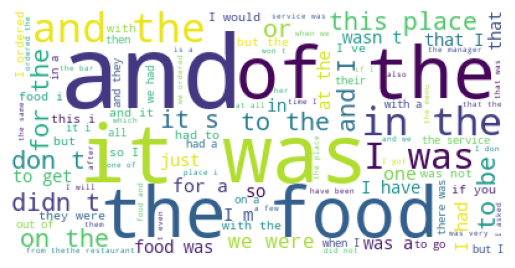

In [26]:
wordcloud = WordCloud(background_color='white',
                        stopwords=[],
                        max_words=100).generate(" ".join(corpus_original))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

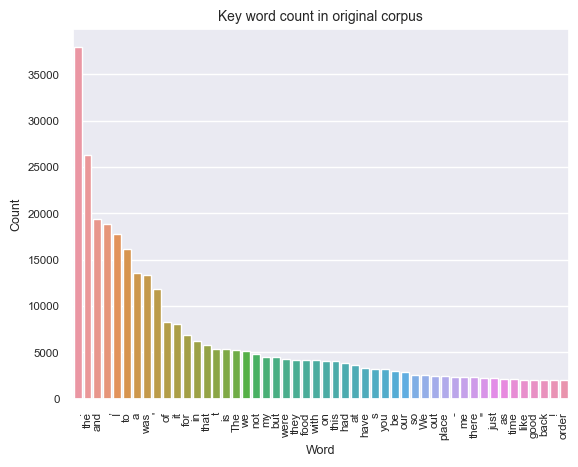

In [27]:
# Bar plot - Create a dataframe of the most common 30 words
common_words = pd.DataFrame(Counter(corpus_original).most_common(50))
common_words.columns = ('Word', 'Count')# Plot a bar chart of the most common 20 words
sns.set(font_scale = 0.75)
sns.barplot(x= common_words['Word'], y=common_words['Count'])
plt.xticks(rotation='vertical')
plt.title("Key word count in original corpus", fontsize = 10)
plt.show()

### Corpus after cleaning

In [28]:
display_tokens_info(corpus_clean)

nb tokens 105092, nb tokens uniques 6971
['month' 'movie' 'burger' 'burger' 'area' 'chocolate' 'cake' 'airy'
 'granular' 'texture' 'sign' 'quality' 'crocker' 'beef' 'sandwich'
 'friend' 'item' 'menu' 'time' 'line' 'portillos' 'hype' 'medium'
 'chicago' 'decor' 'service' 'food' 'waiter' 'time' 'visit']


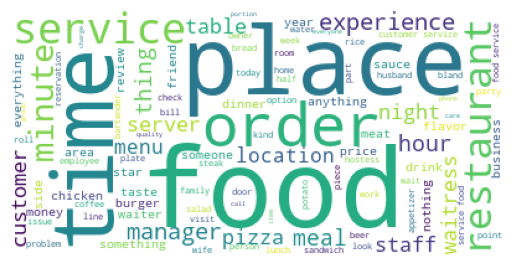

In [29]:
wordcloud = WordCloud(background_color='white',
                        max_words=100).generate(" ".join(corpus_clean))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

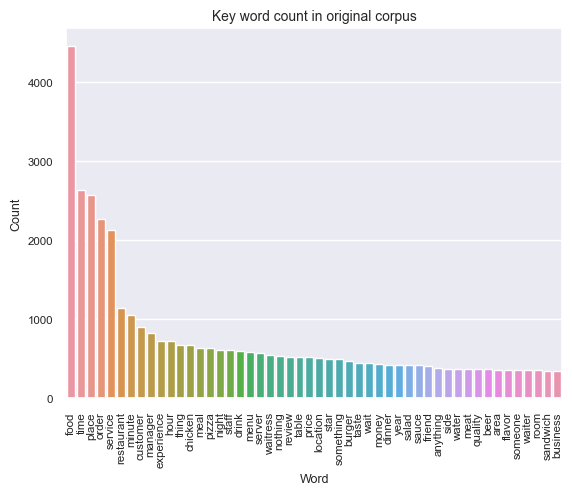

In [30]:
# Bar plot - Create a dataframe of the most common 30 words
common_words = pd.DataFrame(Counter(corpus_clean).most_common(50))
common_words.columns = ('Word', 'Count')# Plot a bar chart of the most common 20 words
sns.set(font_scale = 0.75)
sns.barplot(x= common_words['Word'], y=common_words['Count'])
plt.xticks(rotation='vertical')
plt.title("Key word count in original corpus", fontsize = 10)
plt.show()

In [31]:
common_words = ["food", "time", "place", "order", "service", "restaurant", "minute"]

data.clean_text = data.clean_text.apply(lambda row : [w for w in row if w not in common_words])

In [32]:
data["docs"] = data.clean_text.apply(lambda x : " ".join(x))
data.head(5)

,text,clean_text,docs
0,I waited a month before visiting Portillos to ...,"[month, movie, burger, burger, area, chocolate...",month movie burger burger area chocolate cake ...
1,I walked in and immediately noticed the very p...,"[decor, waiter, visit, seafood, florida, rice,...",decor waiter visit seafood florida rice pork m...
2,"After paying over $600 a night for a room, you...","[night, room, wait, line, paper, coffee, waste...",night room wait line paper coffee waste money
3,"HORRIBLE SERVICE...too bad for me, the wings a...","[industry, year, rush, notice, cocktail, menu,...",industry year rush notice cocktail menu housto...
4,I'm not a local so I don't understand the mass...,"[understand, mass, appeal, bland, crowd, price...",understand mass appeal bland crowd price drive...


## CountVectorizer

In [33]:
cv = CountVectorizer(max_features=1000, ngram_range=(1,2), stop_words={'english'})

cv_vectors = cv.fit_transform(data.docs)

data_cv = pd.DataFrame(cv_vectors.toarray(), columns=cv.get_feature_names_out())
data_cv.index = data.index

data_cv.head(5)

,absolute,account,addition,address,adult,advance,advantage,advice,afternoon,airport,...,worth,wrap,yeah,year,yelp,yelp review,yesterday,york,yuck,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TFIDF

In [34]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words={'english'})

tfidf_vectors = tfidf.fit_transform(data.docs)

data_tfidf = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf.get_feature_names_out())
data_tfidf.index = data.index

data_tfidf.head(5)

,absolute,account,addition,address,adult,advance,advantage,advice,afternoon,airport,...,worth,wrap,yeah,year,yelp,yelp review,yesterday,york,yuck,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.223605,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Train LDA model

### Unigrams

In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data.clean_text)

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data.clean_text]

In [36]:
topics = []
coherence = []

for t in range(2, 10):

    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=t)

    # coherence_model_lda = CoherenceModel(model=lda, texts=data.clean_text, dictionary=id2word, coherence='c_v')
    coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
    topics.append(t)
    coherence.append(coherence_lda)

results = pd.DataFrame(columns=["Topics", "Coherence"])
results["Topics"] = topics
results["Coherence"] = coherence

<AxesSubplot:>

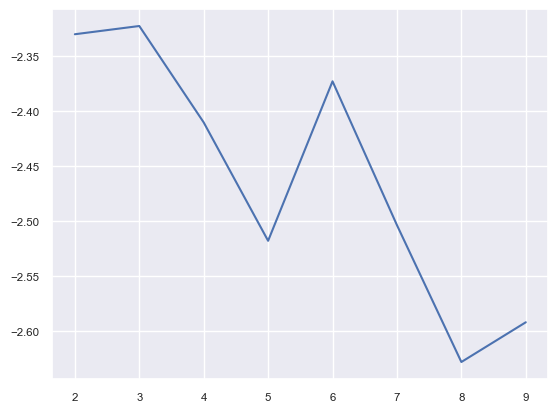

In [37]:
sns.lineplot(results, x=topics, y=coherence)

In [38]:
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=4, alpha=0.1)
lda.print_topics()

[(0,
  '0.020*"chicken" + 0.009*"sandwich" + 0.008*"customer" + 0.008*"rice" + 0.007*"flavor" + 0.007*"location" + 0.007*"lunch" + 0.007*"side" + 0.007*"waitress" + 0.006*"everything"'),
 (1,
  '0.019*"manager" + 0.014*"pizza" + 0.013*"customer" + 0.012*"hour" + 0.009*"meal" + 0.009*"drink" + 0.009*"experience" + 0.008*"thing" + 0.008*"wait" + 0.008*"something"'),
 (2,
  '0.013*"staff" + 0.012*"beer" + 0.010*"night" + 0.009*"drink" + 0.009*"salad" + 0.009*"server" + 0.008*"table" + 0.008*"meal" + 0.008*"room" + 0.008*"experience"'),
 (3,
  '0.011*"experience" + 0.011*"coffee" + 0.011*"hour" + 0.010*"dinner" + 0.010*"price" + 0.009*"thing" + 0.009*"review" + 0.009*"night" + 0.008*"star" + 0.008*"taste"')]

In [35]:
# coherence_model_lda = CoherenceModel(model=lda, texts=data.clean_text, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# coherence_lda

In [ ]:
#0.52

In [39]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.002656 -0.060215       1        1  37.153056
0     -0.076621  0.034819       2        1  21.678751
2      0.022233 -0.030427       3        1  21.385472
3      0.057044  0.055824       4        1  19.782721, topic_info=         Term        Freq       Total Category  logprob  loglift
111   chicken  638.000000  638.000000  Default  30.0000  30.0000
398      beer  350.000000  350.000000  Default  29.0000  29.0000
40     coffee  300.000000  300.000000  Default  28.0000  28.0000
33       rice  278.000000  278.000000  Default  27.0000  27.0000
128     pizza  594.000000  594.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
99    nothing  104.846744  528.157535   Topic4  -5.1217   0.0035
27     flavor   87.427643  337.214148   Topic4  -5.3034   0.2705
41      money   88.838310  401.014579   Topic4  -5.2874   0.1132
94   customer  100.552858  805.766890   Topic4  -5.1635  -0.4607
157    server   85.561800  542.917680   Topic4  -5.3249  -0.2274

[354 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
506       4  0.895199   anybody
60        1  0.452367  anything
60        2  0.162742  anything
60        3  0.281350  anything
60        4  0.102058  anything
...     ...       ...       ...
1018      4  0.155939      wrap
59        1  0.473120      year
59        2  0.174849      year
59        3  0.195419      year
59        4  0.154278      year

[706 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

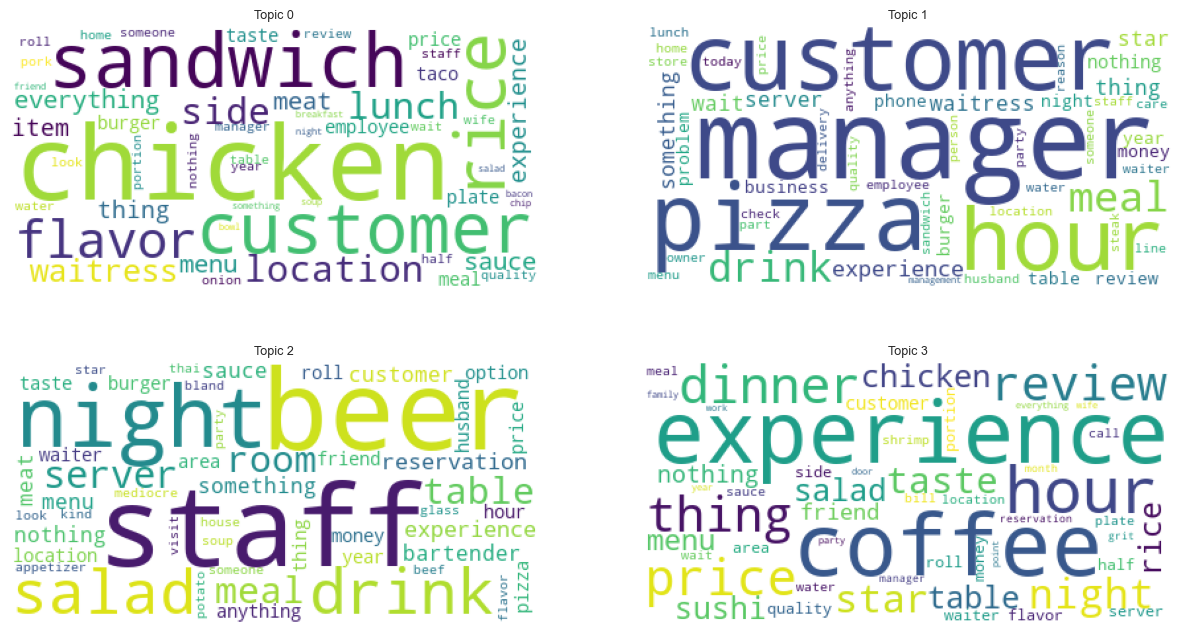

In [40]:
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

## Bigrams

### Form Bigrams

In [67]:
data

,text,clean_text,docs,w_bigrams,w_trigrams
0,I waited a month before visiting Portillos to ...,"[month, movie, burger, burger, area, chocolate...",month movie burger burger area chocolate cake ...,"[month, movie, burger, burger, area, chocolate...","[month, movie, burger, burger, area, chocolate..."
1,I walked in and immediately noticed the very p...,"[decor, waiter, visit, seafood, florida, rice,...",decor waiter visit seafood florida rice pork m...,"[decor, waiter, visit, seafood, florida, rice,...","[decor, waiter, visit, seafood, florida, rice,..."
2,"After paying over $600 a night for a room, you...","[night, room, wait, line, paper, coffee, waste...",night room wait line paper coffee waste money,"[night, room, wait, line, paper, coffee, waste...","[night, room, wait, line, paper, coffee, waste..."
3,"HORRIBLE SERVICE...too bad for me, the wings a...","[industry, year, rush, notice, cocktail, menu,...",industry year rush notice cocktail menu housto...,"[industry, year, rush, notice, cocktail, menu,...","[industry, year, rush, notice, cocktail, menu,..."
4,I'm not a local so I don't understand the mass...,"[understand, mass, appeal, bland, crowd, price...",understand mass appeal bland crowd price drive...,"[understand, mass, appeal, bland, crowd, price...","[understand, mass, appeal, bland, crowd, price..."
...,...,...,...,...,...
4995,I saw reviews and was I interested in trying t...,"[review, sandwich, boyfriend, sandwich, anythi...",review sandwich boyfriend sandwich anything cu...,"[review, sandwich, boyfriend, sandwich, anythi...","[review, sandwich, boyfriend, sandwich, anythi..."
4996,Food and service is horrible. Called to place ...,"[horrible, pick, hung, phone, cold, sticky, rate]",horrible pick hung phone cold sticky rate,"[horrible, pick, hung, phone, cold, sticky, rate]","[horrible, pick, hung, phone, cold, sticky, rate]"
4997,"This is the worse restaurant in St. Charles, M...","[wife, pork, steak, brother, pork, tender, lob...",wife pork steak brother pork tender lobster ra...,"[wife, pork, steak, brother, pork, tender, lob...","[wife, pork, steak, brother, pork, tender, lob..."
4998,We ordered takeout and spent $40 on dinner. It...,"[spent, dinner, bread, roach, point]",spent dinner bread roach point,"[spent, dinner, bread, roach, point]","[spent, dinner, bread, roach, point]"


In [41]:
data["w_bigrams"] = data.clean_text

before_bigrams = len(np.concatenate(data.w_bigrams))

bigram = Phrases(data.w_bigrams, min_count=5, threshold=100)
for idx in range(len(data.w_bigrams)):
    for token in bigram[data.w_bigrams[idx]]:
        if '_' in token:
            data.w_bigrams[idx].append(token)

after_bigrams = len(np.concatenate(data.w_bigrams))

print(f"We added "+ str(after_bigrams - before_bigrams) + " bigrams.")

We added 504 bigrams.


In [42]:
# Create Dictionary
id2word = corpora.Dictionary(data.w_bigrams)

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data.w_bigrams]

In [43]:
topics = []
coherence = []
perplexity = []

for t in range(2, 10):

    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=t)

    # coherence_model_lda = CoherenceModel(model=lda, texts=data.w_bigrams, dictionary=id2word, coherence='c_v')
    coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
    topics.append(t)
    coherence.append(coherence_lda)

results_bg = pd.DataFrame(columns=["Topics", "Coherence"])
results_bg["Topics"] = topics
results_bg["Coherence"] = coherence

<AxesSubplot:>

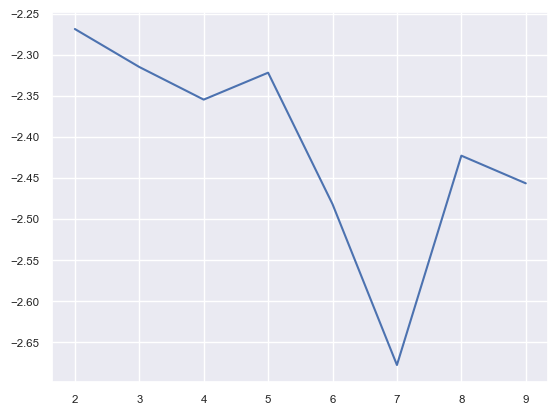

In [44]:
sns.lineplot(results_bg, x=topics, y=coherence)

In [45]:
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5)
lda.print_topics()

[(0,
  '0.024*"chicken" + 0.011*"experience" + 0.010*"flavor" + 0.010*"review" + 0.008*"taste" + 0.008*"coffee" + 0.008*"sauce" + 0.007*"roll" + 0.007*"meal" + 0.007*"home"'),
 (1,
  '0.016*"beer" + 0.014*"burger" + 0.012*"drink" + 0.010*"nothing" + 0.009*"thing" + 0.009*"server" + 0.009*"water" + 0.008*"night" + 0.008*"star" + 0.008*"side"'),
 (2,
  '0.014*"meal" + 0.012*"room" + 0.011*"table" + 0.009*"party" + 0.009*"salad" + 0.009*"dinner" + 0.008*"menu" + 0.008*"husband" + 0.007*"staff" + 0.007*"night"'),
 (3,
  '0.012*"pizza" + 0.011*"rice" + 0.011*"staff" + 0.010*"meat" + 0.009*"customer" + 0.008*"steak" + 0.008*"taste" + 0.007*"money" + 0.007*"quality" + 0.007*"flavor"'),
 (4,
  '0.020*"manager" + 0.019*"customer" + 0.014*"hour" + 0.012*"pizza" + 0.011*"experience" + 0.009*"waitress" + 0.009*"phone" + 0.009*"employee" + 0.008*"sandwich" + 0.008*"table"')]

In [46]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.102981  0.035572       1        1  31.074555
2     -0.016772 -0.058604       2        1  18.560550
3      0.048870  0.026279       3        1  17.625338
0      0.047787  0.059576       4        1  17.336793
1      0.023095 -0.062822       5        1  15.402764, topic_info=        Term        Freq       Total Category  logprob  loglift
111  chicken  637.000000  637.000000  Default  30.0000  30.0000
400     beer  342.000000  342.000000  Default  29.0000  29.0000
128    pizza  590.000000  590.000000  Default  28.0000  28.0000
3     burger  390.000000  390.000000  Default  27.0000  27.0000
44      room  314.000000  314.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
96      half   62.316753  347.218895   Topic5  -5.3973   0.1529
108   review   65.206863  485.735204   Topic5  -5.3520  -0.1375
111  chicken   68.042679  637.770195   Topic5  -5.3094  -0.3672
18   quality   59.931797  365.251060   Topic5  -5.4364   0.0632
70     price   59.410675  471.054895   Topic5  -5.4451  -0.1999

[433 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
88        1  0.959535     adam
507       1  0.139111  airport
507       2  0.834666  airport
684       3  0.843449  alright
684       4  0.093717  alright
...     ...       ...      ...
59        1  0.287456     year
59        2  0.272057     year
59        3  0.082130     year
59        4  0.243824     year
59        5  0.112929     year

[956 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

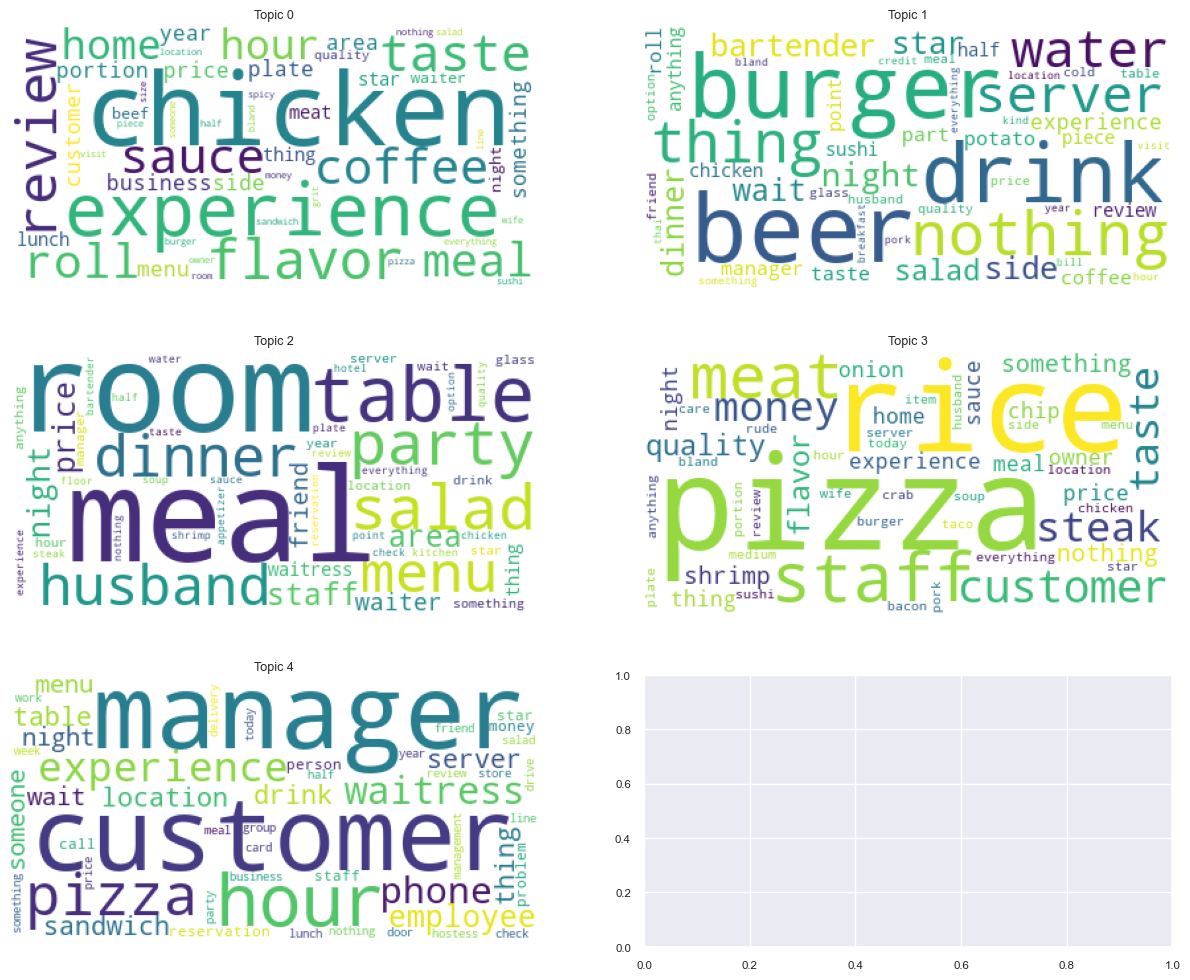

In [47]:
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

## Trigrams

### Form Trigrams

In [49]:
data["w_trigrams"] = data.w_bigrams

before_trigrams = len(np.concatenate(data.w_trigrams))

trigram = Phrases(data.w_trigrams, min_count=5, threshold=100)
for idx in range(len(data.w_trigrams)):
    for token in trigram[data.w_trigrams[idx]]:
        if '_' in token:
            data.w_trigrams[idx].append(token)

after_trigrams = len(np.concatenate(data.w_trigrams))

print(f"We added "+ str(after_trigrams - before_trigrams) + " trigrams.")

We added 1008 trigrams.


In [50]:
# Create Dictionary
id2word = corpora.Dictionary(data.w_trigrams)

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data.w_trigrams]

In [51]:
topics = []
coherence = []

for t in range(2, 10):

    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=t)

    # coherence_model_lda = CoherenceModel(model=lda, texts=data.w_trigrams, dictionary=id2word, coherence='c_v')
    coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
    topics.append(t)
    coherence.append(coherence_lda)

results_tg = pd.DataFrame(columns=["Topics", "Coherence"])
results_tg["Topics"] = topics
results_tg["Coherence"] = coherence

<AxesSubplot:>

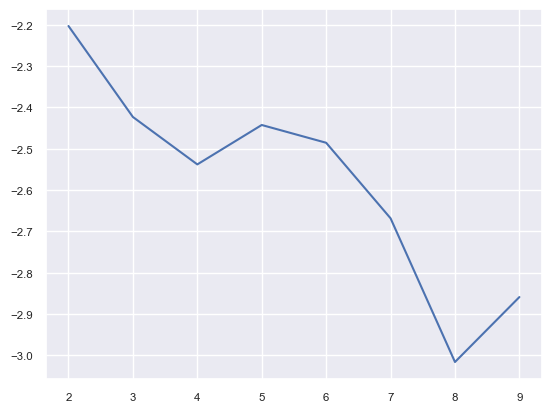

In [52]:
sns.lineplot(results_tg, x=topics, y=coherence)

In [53]:
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5)
lda.print_topics()

[(0,
  '0.017*"customer" + 0.017*"hour" + 0.015*"pizza" + 0.015*"manager" + 0.011*"experience" + 0.011*"night" + 0.010*"location" + 0.008*"nothing" + 0.007*"phone" + 0.007*"dinner"'),
 (1,
  '0.014*"coffee" + 0.012*"meal" + 0.011*"credit_card" + 0.010*"star" + 0.008*"side" + 0.008*"waitress" + 0.008*"experience" + 0.008*"card" + 0.007*"thing" + 0.007*"night"'),
 (2,
  '0.020*"chicken" + 0.011*"nothing" + 0.010*"sandwich" + 0.010*"server" + 0.010*"salad" + 0.008*"flavor" + 0.008*"burger" + 0.008*"taste" + 0.008*"meat" + 0.007*"roll"'),
 (3,
  '0.015*"drive_thru" + 0.012*"rice" + 0.009*"steak" + 0.009*"thing" + 0.008*"sushi" + 0.008*"star" + 0.008*"chicken" + 0.008*"taste" + 0.007*"sauce" + 0.007*"customer"'),
 (4,
  '0.017*"table" + 0.015*"manager" + 0.013*"staff" + 0.010*"server" + 0.009*"burger" + 0.009*"year" + 0.009*"beer" + 0.009*"drink" + 0.009*"price" + 0.008*"wait"')]

In [54]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.029809 -0.003262       1        1  31.026680
2     -0.026438 -0.028525       2        1  21.750478
1      0.012677 -0.077311       3        1  20.133001
4      0.084303  0.061040       4        1  16.338660
3     -0.100351  0.048058       5        1  10.751181, topic_info=            Term        Freq       Total Category  logprob  loglift
670   drive_thru  166.000000  166.000000  Default  30.0000  30.0000
40        coffee  301.000000  301.000000  Default  29.0000  29.0000
490  credit_card  223.000000  223.000000  Default  28.0000  28.0000
111      chicken  656.000000  656.000000  Default  27.0000  27.0000
83         table  524.000000  524.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
70         price   46.241541  473.492499   Topic5  -5.3474  -0.0961
368   everything   41.449939  335.628640   Topic5  -5.4568   0.1386
29          meal   42.885321  616.320350   Topic5  -5.4227  -0.4351
162    something   41.378053  469.398111   Topic5  -5.4585  -0.1985
128        pizza   41.553564  592.949776   Topic5  -5.4543  -0.4280

[422 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
322       2  0.101222   allergy
322       3  0.050611   allergy
322       4  0.809778   allergy
322       5  0.050611   allergy
60        1  0.368517  anything
...     ...       ...       ...
59        1  0.409236      year
59        2  0.048597      year
59        3  0.092078      year
59        4  0.347850      year
59        5  0.102309      year

[966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

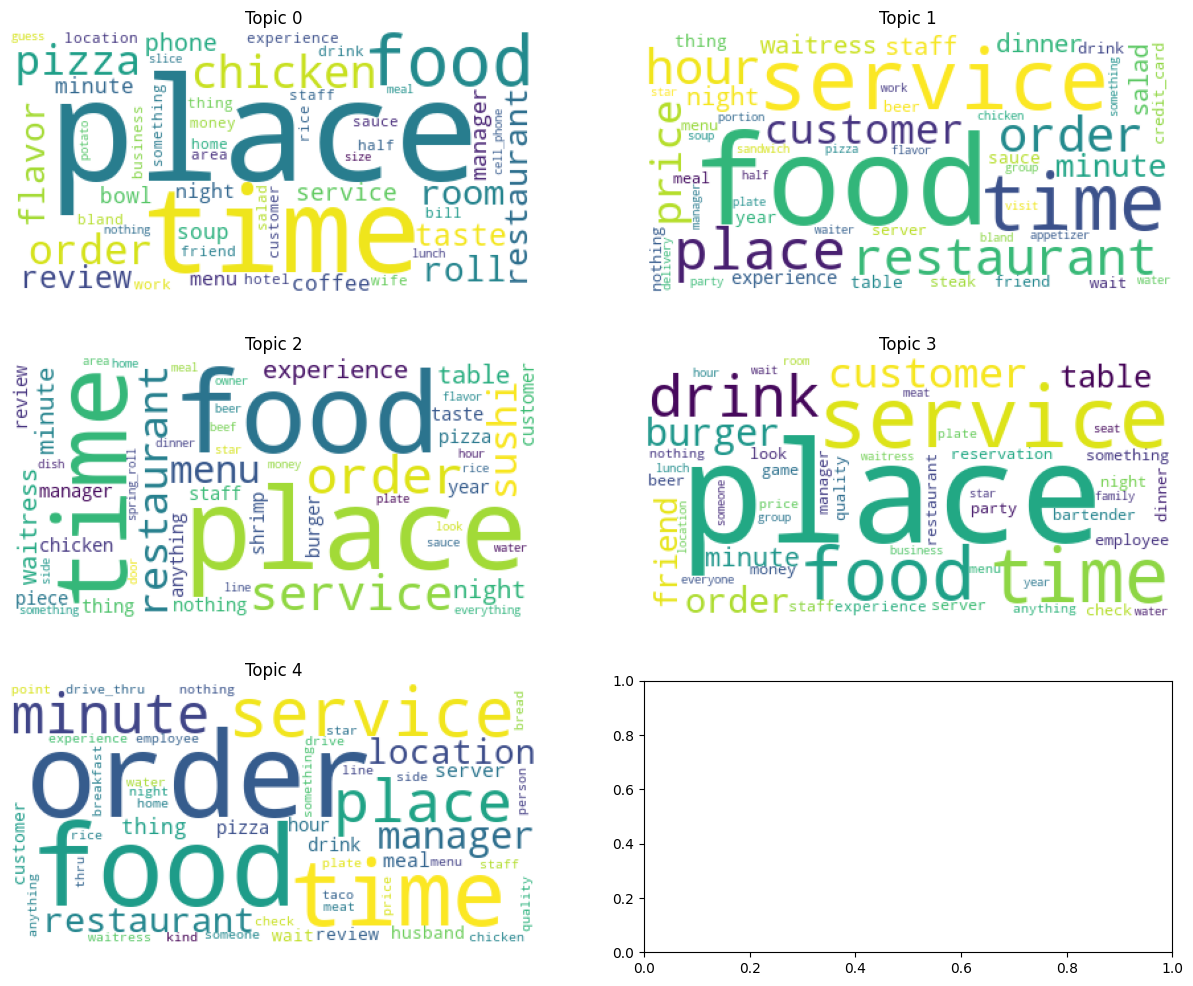

In [ ]:
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

In [66]:
data

,text,clean_text,docs,w_bigrams,w_trigrams
0,I waited a month before visiting Portillos to ...,"[month, movie, burger, burger, area, chocolate...",month movie burger burger area chocolate cake ...,"[month, movie, burger, burger, area, chocolate...","[month, movie, burger, burger, area, chocolate..."
1,I walked in and immediately noticed the very p...,"[decor, waiter, visit, seafood, florida, rice,...",decor waiter visit seafood florida rice pork m...,"[decor, waiter, visit, seafood, florida, rice,...","[decor, waiter, visit, seafood, florida, rice,..."
2,"After paying over $600 a night for a room, you...","[night, room, wait, line, paper, coffee, waste...",night room wait line paper coffee waste money,"[night, room, wait, line, paper, coffee, waste...","[night, room, wait, line, paper, coffee, waste..."
3,"HORRIBLE SERVICE...too bad for me, the wings a...","[industry, year, rush, notice, cocktail, menu,...",industry year rush notice cocktail menu housto...,"[industry, year, rush, notice, cocktail, menu,...","[industry, year, rush, notice, cocktail, menu,..."
4,I'm not a local so I don't understand the mass...,"[understand, mass, appeal, bland, crowd, price...",understand mass appeal bland crowd price drive...,"[understand, mass, appeal, bland, crowd, price...","[understand, mass, appeal, bland, crowd, price..."
...,...,...,...,...,...
4995,I saw reviews and was I interested in trying t...,"[review, sandwich, boyfriend, sandwich, anythi...",review sandwich boyfriend sandwich anything cu...,"[review, sandwich, boyfriend, sandwich, anythi...","[review, sandwich, boyfriend, sandwich, anythi..."
4996,Food and service is horrible. Called to place ...,"[horrible, pick, hung, phone, cold, sticky, rate]",horrible pick hung phone cold sticky rate,"[horrible, pick, hung, phone, cold, sticky, rate]","[horrible, pick, hung, phone, cold, sticky, rate]"
4997,"This is the worse restaurant in St. Charles, M...","[wife, pork, steak, brother, pork, tender, lob...",wife pork steak brother pork tender lobster ra...,"[wife, pork, steak, brother, pork, tender, lob...","[wife, pork, steak, brother, pork, tender, lob..."
4998,We ordered takeout and spent $40 on dinner. It...,"[spent, dinner, bread, roach, point]",spent dinner bread roach point,"[spent, dinner, bread, roach, point]","[spent, dinner, bread, roach, point]"


In [57]:
comparison = np.where(data.w_trigrams == data.clean_text, 'True', 'False')

In [65]:
Counter(comparison)

Counter({'True': 5000})